### Y bienvenidos a la Semana 4, Día 3: más LangGraph.

In [ ]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langchain_openai import ChatOpenAI
from typing import TypedDict

In [ ]:
# ¡Nuestro primer paso favorito! Por cierto, la tripulación lo estaba haciendo por nosotros.
load_dotenv(override=True)

True

### Primero, vayamos a configurar LangSmith!

https://langsmith.com

### A continuación, se muestra una función útil en la comunidad LangChain:

In [3]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper = GoogleSerperAPIWrapper()
serper.run("¿Cuál es la capital de Francia?")

'Paris'

### Ahora aquí hay una clase contenedora LangChain para convertir funciones en herramientas

In [ ]:
from langchain.agents import Tool

tool_search =Tool(
        name="search",
        func=serper.run,
        description="Útil cuando necesitas más información de una búsqueda en línea."
    )

### Ahora podemos probar la herramienta al estilo Langchain.

In [6]:
tool_search.invoke("¿Cuál es la capital de Francia?")

'Paris'

### Y ahora, escribamos una herramienta nosotros mismos.

Elegiremos una que nos resulte familiar.

In [5]:
pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = "https://api.pushover.net/1/messages.json"

def push(text: str):
    """Envía una notificación push al usuario"""
    requests.post(pushover_url, data = {
        "token": pushover_token, 
        "user": pushover_user, 
        "message": text})

In [6]:
tool_push = Tool(
        name="send_push_notification",
        func=push,
        description="Útil para cuando quieras enviar una notificación push"
    )

tool_push.invoke("¡Hola, tú!")

### Volviendo al grafo, como ayer

Un pequeño cambio: usar TypedDict en lugar de BaseModel para el objeto State

Al implementar herramientas, siempre debemos realizar dos cambios en el código:

1. Cambios para proporcionar las herramientas a OpenAI en formato JSON al realizar la llamada.

2. Cambios para gestionar los resultados: buscar el modelo manteniendo el argumento finish_reason=="tool_calls" y luego recuperar la llamada, ejecutar la función y proporcionar los resultados.

### Lo juntamos todo

In [7]:
tools = [tool_search, tool_push]

In [8]:
# Paso 1: Definir el objeto Estado
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [9]:
# Paso 2: Iniciar el constructor del Grafo con la clase Estado
graph_builder = StateGraph(State)

In [ ]:
# Esto es diferente:
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

In [ ]:
# Paso 3: Creamos un Nodo
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

In [ ]:
# Paso 4: Creamos Aristas
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")

# Cada vez que se llama a una herramienta, volvemos al chatbot para decidir el siguiente paso.
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

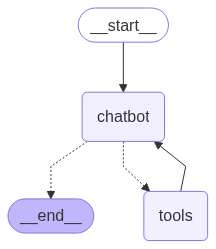

In [ ]:
# Paso 5: Compilamos el Grafo

graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

### ¡Listo! Y, ¡hagamos esto!

In [ ]:
def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
    return result["messages"][-1].content

gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


## ¡Es hora de agregar memoria!

### ¡PERO ESPERA!

Tenemos este grafo completo manteniendo el estado y añadiendo elementos adicionales.

¿Por qué no gestiona la memoria?

### Este es un punto crucial para comprender LangGraph.

> Un superpaso puede considerarse una única iteración sobre los nodos del grafo. Los nodos que se ejecutan en paralelo forman parte del mismo superpaso, mientras que los que se ejecutan secuencialmente pertenecen a superpasos separados.

Un "superpaso" del grafo representa una invocación de intercambio de mensajes entre agentes.

En LangGraph idomático, se llama a la función "invocar" para ejecutar el grafo en cada superpaso; en cada interacción.

El reductor gestiona las actualizaciones de estado automáticamente dentro de un superpaso, pero no entre ellos.

Esto es lo que se consigue con los puntos de control.

In [23]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

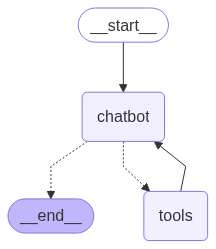

In [ ]:
# Steps 1 and 2
graph_builder = StateGraph(State)

# Step 3
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "1"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content

gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7867
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hola', additional_kwargs={}, response_metadata={}, id='07e7f4e6-b84e-4791-bd65-f29d11eb0cf5'), AIMessage(content='¡Hola! ¿Cómo puedo ayudarte hoy?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 89, 'total_tokens': 99, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BoYrf8cdGAHdWNUuwZPmdoGhHJS4o', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--98a2256a-b75b-43f4-b1ed-0cf490a54002-0', usage_metadata={'input_tokens': 89, 'output_tokens': 10, 'total_tokens': 99, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='sabes mi nombr

In [20]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='hola', additional_kwargs={}, response_metadata={}, id='6c5e9b9f-4be1-4f64-bc54-64d581ae5c0e'), AIMessage(content='¡Hola! ¿Cómo puedo ayudarte hoy?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 89, 'total_tokens': 99, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BoYlgQGgQqCsEHVjvBEDdttFTVJtG', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--c2f0569d-09f9-4165-82e6-aa73b581c205-0', usage_metadata={'input_tokens': 89, 'output_tokens': 10, 'total_tokens': 99, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(co

In [28]:
# Most recent first

list(graph.get_state_history(config))

[StateSnapshot(values={'messages': [HumanMessage(content='hola', additional_kwargs={}, response_metadata={}, id='07e7f4e6-b84e-4791-bd65-f29d11eb0cf5'), AIMessage(content='¡Hola! ¿Cómo puedo ayudarte hoy?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 89, 'total_tokens': 99, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BoYrf8cdGAHdWNUuwZPmdoGhHJS4o', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--98a2256a-b75b-43f4-b1ed-0cf490a54002-0', usage_metadata={'input_tokens': 89, 'output_tokens': 10, 'total_tokens': 99, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(c

### LangGraph te ofrece herramientas para restablecer el estado a un punto anterior y ramificarlo:

```
config = {"configurable": {"thread_id": "1", "checkpoint_id": ...}}
graph.invoke(None, config=config)
```

Esto te permite crear sistemas estables que se pueden recuperar y volver a ejecutar desde cualquier punto de control anterior.

### Y ahora almacenemos en SQL

### Y este es el poder de LangGraph.


In [12]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = "memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
sql_memory = SqliteSaver(conn)

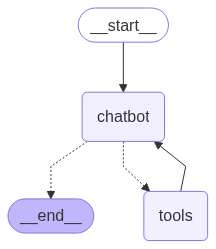

In [ ]:
# Pasos 1 y 2
graph_builder = StateGraph(State)

# Paso 3
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Paso 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Paso 5
graph = graph_builder.compile(checkpointer=sql_memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "3"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content

gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hola', additional_kwargs={}, response_metadata={}, id='57fd15a9-8c82-42bf-820e-136492855f42'), AIMessage(content='¡Hola! ¿Cómo puedo ayudarte hoy?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 89, 'total_tokens': 99, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BoZ11xH1r7FcEwOY2r8Nmwe7I3OuH', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--9eda60d5-bcc2-48ca-a6c4-bebe0ebda90c-0', usage_metadata={'input_tokens': 89, 'output_tokens': 10, 'total_tokens': 99, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='cómo me llamo?